#LeNet Architcture

Connecting to Google Drive

In [2]:
# Connect to Google Drive to access dataset
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
training_path = r"/content/gdrive/MyDrive/DATASET/Training"
testing_path = r"/content/gdrive/MyDrive/DATASET/Testing"
validation_path = r"/content/gdrive/MyDrive/DATASET/Validation"

# Importing Libraries

In [4]:
import os
from pathlib import Path

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

# Image-Preprocessing

In [7]:
classes = os.listdir(training_path)
classes

['malignant', 'normal', 'benign']

In [8]:
paths = Path(training_path)

#paths.glob('**/*.png') is used to get all the file paths of png images recursively in the paths 
path_images = list(paths.glob('**/*.png'))
images_paths = [str(path_image) for path_image in path_images ]
print(f'Number of training images: {len(images_paths)}')

#creates a list labels which contains the label of each image in the images_paths list
labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]

Number of training images: 623


Random Training Images: 


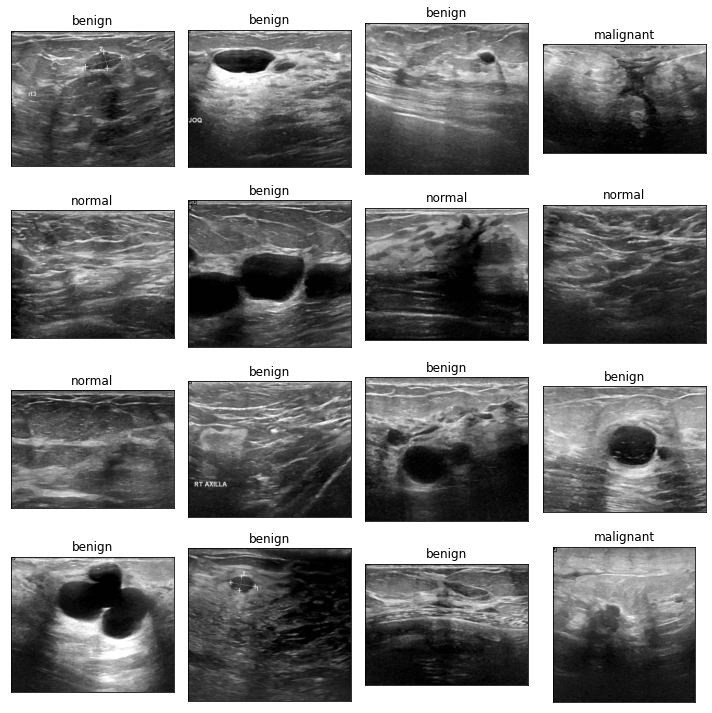

In [9]:

# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(images_paths), 16)
fig, axes = plt.subplots(4,4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

print('Random Training Images: ')

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_paths[random_index[i]]))
    ax.set_title(labels[random_index[i]])
plt.tight_layout()
plt.show()

#Normalization

In [10]:
pretrained_size = 32
pretrained_means = [0.5]
pretrained_stds = [0.5]

train_transforms = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
])
test_transforms = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])

valid_transforms = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])


# Splitting the Dataset

In [11]:
train_dataset = torchvision.datasets.ImageFolder(root= training_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root= testing_path, transform = test_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root= validation_path, transform = valid_transforms)

In [12]:
len(train_dataset)

623

In [13]:
len(test_dataset)

155

In [14]:
len(valid_dataset)

154

In [15]:
# Hyper parameters
epochs = 30
num_classes = 3
batch_size = 32
learning_rate = 0.001

In [16]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [17]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True,num_workers=2)
valid_loader = DataLoader(dataset = valid_dataset,  batch_size = batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

# Designing a Convolution Neural Network (CNN): LeNet

In [18]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding=0,
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0,
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=5,
            stride=1,
            padding=0,
        )
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(
            self.conv3(x)
        )  # num_examples x 120 x 1 x 1 --> num_examples x 120
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x


In [19]:
model = LeNet()
print(model)

LeNet(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=3, bias=True)
)


# Loss & Optimization

In [20]:
model = LeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

#Adam optimizer 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  

In [21]:
%%time
# keeping-track-of-losses and accuracy
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(1, epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss and accuracy
        train_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        train_acc += torch.sum(pred == target.data)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss and accuracy
        valid_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        valid_acc += torch.sum(pred == target.data)
    
    # calculate-average-losses and accuracy
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(100. * train_acc/len(train_loader.sampler))
    valid_accuracies.append(100. * valid_acc/len(valid_loader.sampler))
        
    # print-training/validation-statistics 
    print('Epoch: [{}/{}] \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
        epoch, epochs, train_loss, valid_loss,))
    print('Training Accuracy: {:.6f}% '.format(
         train_accuracies[-1]))
    print('Validation Accuracy: {:.6f}%\n'.format(
         valid_accuracies[-1]))

Epoch: [1/30] 	Training Loss: 1.036249 	Validation Loss: 0.951253 
Training Accuracy: 51.524879% 
Validation Accuracy: 56.129032%

Epoch: [2/30] 	Training Loss: 0.965740 	Validation Loss: 0.924555 
Training Accuracy: 55.698235% 
Validation Accuracy: 56.129032%

Epoch: [3/30] 	Training Loss: 0.932720 	Validation Loss: 0.873401 
Training Accuracy: 56.500801% 
Validation Accuracy: 61.935482%

Epoch: [4/30] 	Training Loss: 0.890988 	Validation Loss: 0.865409 
Training Accuracy: 60.834671% 
Validation Accuracy: 61.290321%

Epoch: [5/30] 	Training Loss: 0.869674 	Validation Loss: 0.861925 
Training Accuracy: 61.637238% 
Validation Accuracy: 63.870968%

Epoch: [6/30] 	Training Loss: 0.832185 	Validation Loss: 0.852159 
Training Accuracy: 64.365974% 
Validation Accuracy: 62.580643%

Epoch: [7/30] 	Training Loss: 0.815749 	Validation Loss: 0.835492 
Training Accuracy: 64.526482% 
Validation Accuracy: 61.935482%

Epoch: [8/30] 	Training Loss: 0.806708 	Validation Loss: 0.839804 
Training Accurac

In [22]:
# Connect to Google Drive to access dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
# saving model
torch.save(model.state_dict(), '/content/gdrive/MyDrive/LeNet.pth')

In [24]:
# loading model
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/LeNet_Updated.pth'))

# Validation

In [25]:
valid_acc1 =  [float(i.cpu()) for i in valid_accuracies]
train_acc1 =  [float(i.cpu()) for i in train_accuracies]

In [26]:
df = pd.DataFrame({
    'Epochs': range(1, 31),
    'Train loss': train_losses,
    'Valid loss': valid_losses,
    'Train acc': train_acc1,
    'Valid acc': valid_acc1,
})

In [27]:
df.to_csv("LeNet.csv", index = True)

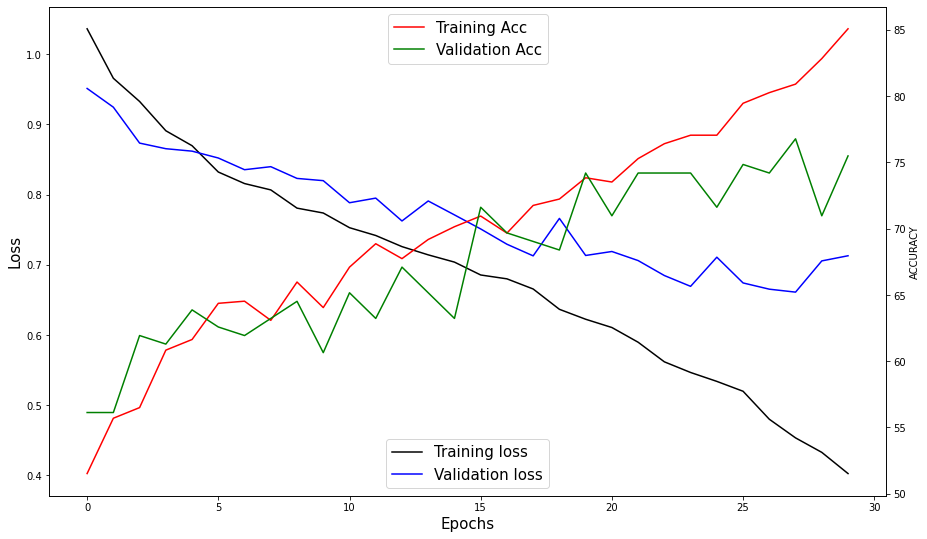

In [28]:
%matplotlib inline

fig, axes = plt.subplots(1,1, figsize = (15,9))

ax = plt.subplot(1,1,1)
ax.plot(train_losses, label='Training loss', color = 'black')
ax.plot(valid_losses, label='Validation loss', color = 'blue')
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)

ax1 = ax.twinx()
ax1.plot(train_acc1, label = "Training Acc", color = 'red')
ax1.plot(valid_acc1, label = 'Validation Acc', color = 'green')
ax1.set_ylabel("ACCURACY")


ax1.legend(loc = 'upper center', fontsize = 15)
ax.legend(loc = 'lower center', fontsize = 15)

fig.savefig("TrainingVsValidation_LeNet.png",dpi = 500, bbox_inches = 'tight')